[8278, 26629, 4409, 382, 302]
40000
100%|██████████| 40000/40000 [03:32<00:00, 188.32it/s]
Color Distribution: 

8278
26629
4409
382
302


Answer Distribution: 

6944.0
6960.0
6929.0
6964.0
6903.0


Correct Answer Distribution: 

5376.0
5293.0
5390.0
5332.0
5374.0


Total Correct Answer: 5293
Probability Correct Answer: 
0.132325
Total Not Picked: 5300
[8278, 26629, 4409, 382, 302]
40000
100%|██████████| 40000/40000 [02:14<00:00, 297.92it/s]
Color Distribution: 

8278
26629
4409
382
302


Answer Distribution: 

59.0
25089.0
9.0
0.0
0.0


Correct Answer Distribution: 

59.0
14761.0
9.0
0.0
0.0


Total Correct Answer: 14761
Probability Correct Answer: 
0.369025
Total Not Picked: 14843
[8278, 26629, 4409, 382, 302]
40000
100%|██████████| 40000/40000 [02:42<00:00, 246.84it/s]
Color Distribution: 

8278
26629
4409
382
302


Answer Distribution: 

5076.0
5124.0
5054.0
5068.0
5042.0


Correct Answer Distribution: 

2927.0
2997.0
2955.0
2968.0
2939.0


Total Correct Answer: 2997
Probability Co

<Figure size 1080x576 with 0 Axes>

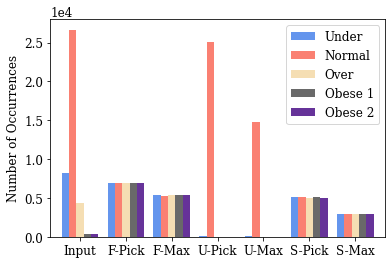

In [ ]:
import distributions
import fair_secretary as fs
import unfair_secretary as ufs 
import synthetic_data as syn_data
import numpy as np
import secretary_eval as se
from utils import SecretaryInstance, GetThreshold, ComputeThreshold
from secretary_data import GetSecretaryInputBank, GetSecretaryInputPokec, GetSecretaryInputUfrgs

from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import sys

def PrintStatistics(data):
    Fair_pick = sum(data['F-Pick'])
    SCSA_pick = sum(data['S-Pick'])
    ratio_pick = round((Fair_pick / SCSA_pick), 3)
    perc_pick = round((ratio_pick - 1) * 100, 1)
    
    Fair_max = sum(data['F-Max'])
    SCSA_max = sum(data['S-Max'])
    ratio_max = round((Fair_max / SCSA_max), 3)
    perc_max = round((ratio_max - 1) * 100, 1)

    print("Pick ratio (Fair > SCSA): {}    Pick percentage (Fair > SCSA): {}".format(ratio_pick, perc_pick))
    print("Max ratio (Fair > SCSA): {}    Max percentage (Fair > SCSA): {}".format(ratio_max, perc_max))

def SecretaryExperiment(sizes, prob, num_rep, mode, data_mode):
    """
    This function runs the experiment for one algorithm. 

    args:
        sizes (list): size of every input color
        prob (list): probability for every color
        num_rep (int): number of experiment repetitions
        mode (string): algorithm to use 
            'F'= Fair
            'U'= SA
            'S'= SCSA
        data_mode (string): data set to use
            'synth' = Synthetic generated
            'bank' = Portuguese banking
            'pokec' = Pokec social network
            'ufrgs' = UFRGS exam entrance and GPA
    
    returns:
        data (dict): results of experiments to plot
    """

    if data_mode == "synth":
        instance = syn_data.GetSecretaryInput(sizes, prob)
    
    if data_mode == "bank":
        instance = GetSecretaryInputBank(100000)

    if data_mode == "pokec":
        # Create new instance (slow)
        # instance = GetSecretaryInputPokec(40000)

        # Load instance from file (faster)
        instance = pickle.load(open('data/pokec_instance.dat', 'rb'))

    if data_mode == "ufrgs":
        instance = GetSecretaryInputUfrgs(100000)
    
    color_dis = Counter([element.color for element in instance])
    colors = sorted(color_dis.keys())
    sizes = [color_dis[color] for color in colors]
    print(sizes)
    print(sum(sizes))
    num_colors = len(sizes)
    threshold = [single_prob * sum(sizes) for single_prob in GetThreshold(prob)]

    answer = []    
    
    # Extract colours and values from instance for optimisation
    in_colours = []
    in_values = []

    for element in instance:
        in_colours.append(element.color)
        in_values.append(element.value)
    
    in_colours = np.array(in_colours)
    in_values = np.array(in_values)

    for _ in tqdm(range(num_rep)):
        shuffler = np.random.permutation(len(instance))
        instance = np.array(instance)[shuffler]
        in_colours = in_colours[shuffler]
        in_values = in_values[shuffler]

        # Fair
        if mode == "F":
            answer.append(fs.ComputeSolutionOpt(instance, in_colours, in_values, num_colors, threshold))
        
        # Unfair SA
        if mode == "U":
            answer.append(ufs.ComputeSolutionOpt(instance, in_values))

        # Unfair SCSA
        if mode == "S":
            answer.append(ufs.ComputeSolutionSingleColorOpt(instance, in_colours, in_values, prob))

    return se.Eval(instance, answer, num_colors)


def PlotSecretary(num_rep, sizes, prob, file_name, data_mode):
    """
    This function creates a plot of all experiment results. 

    args:
        num_rep (int): number of experiment repetitions
        sizes (list): size of every input color
        prob (list): probability for every color
        file_name (string): output plot location 
        data_mode (string): data set to use
            'synth' = Synthetic generated
            'bank' = Portuguese banking
            'pokec' = Pokec social network
            'ufrgs' = UFRGS exam entrance and GPA
    """
    
    data = {"Input" : []}
    num_colors = len(prob)

    # Generate data for plot
    for mode in ['F', 'U', 'S']:
        sizes, num_answer, correct_answer = SecretaryExperiment(sizes, prob, num_rep, mode, data_mode)

        # Add results to data
        data[mode + "-Pick"] = num_answer
        data[mode + "-Max"] = correct_answer

    data["Input"] = sizes
    print(data)
    PrintStatistics(data)
    
    # Create plot
    plt.figure(figsize=(15, 8))

    # Plot labels and colors to corresponding plot type
    if data_mode == 'synth':
        df = pd.DataFrame.from_dict(data, orient='index', 
            columns=['Color ' + str(i+1) for i in range(num_colors)])
        ax = df.plot.bar(width=0.8, 
            color=['cornflowerblue', 'salmon', 'wheat', 'dimgrey'])\

        # Recreate y-axis limit and ticks as in paper
        if len(np.unique(np.array(prob))) == 1:
            ax.yaxis.set_ticks(np.linspace(0, 1, num=3) * 1e4)
            plt.ylim(0, 1.2 * 1e4)
        
        else:
            ax.yaxis.set_ticks(np.linspace(0, 1, num=6) * 1e4)
            plt.ylim(0, 1 * 1e4)
    
    if data_mode == 'bank':
        df = pd.DataFrame.from_dict(data, orient='index', 
            columns=['Before 30', '31-40', '41-50', '51-60', 'After 60'])
        ax = df.plot.bar(width=0.8,
            color=['cornflowerblue', 'salmon', 'wheat', 'dimgrey', 'rebeccapurple'])

        # Recreate y-axis limit and ticks as in paper
        ax.yaxis.set_ticks(np.linspace(0, 1.5, num=4) * 1e4)
        plt.ylim(0, 1.65 * 1e4)
        
    if data_mode == 'pokec':
        df = pd.DataFrame.from_dict(data, orient='index', 
            columns=['Under', 'Normal', 'Over', 'Obese 1', 'Obese 2'])
        ax = df.plot.bar(width=0.8,
            color=['cornflowerblue', 'salmon', 'wheat', 'dimgrey', 'rebeccapurple'])

        # Recreate y-axis limit and ticks as in paper
        ax.yaxis.set_ticks(np.linspace(0, 2.5, num=6) * 1e4)
        plt.ylim(0, 2.8 * 1e4)

    if data_mode == 'ufrgs':
        df = pd.DataFrame.from_dict(data, orient='index', 
            columns=['Female', 'Male'])
        ax = df.plot.bar(width=0.8, color=['cornflowerblue', 'salmon'])

    plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
    ax.set_ylabel('Number of Occurrences')
    plt.xticks(rotation=0)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.savefig(file_name, bbox_inches='tight', dpi=400)
    plt.show()

# Number of experiment repetitions 
num_rep = 20000
num_rep_pokec = 40000

# Variables for synthetic experiments (equal p, general p)
sizes = [10, 100, 1000, 10000]
equal_prob = [0.25, 0.25, 0.25, 0.25]
general_prob = [0.3, 0.25, 0.25, 0.2]

# Variables for maximization dataset experiments (bank, pokec)
max_prob = [0.2, 0.2, 0.2, 0.2, 0.2]

# Variables for research extention dataset experiment (ufrgs)
ufrgs_prob = [0.5, 0.5]

# Uncomment to run experiment
# PlotSecretary(num_rep, sizes, equal_prob, 'plots/Secretaryplot_equal.png', 'synth')
# PlotSecretary(num_rep, sizes, general_prob, 'test.png', 'synth')
# PlotSecretary(num_rep, [], max_prob, 'plots/Secretaryplot_bank.png', 'bank')
PlotSecretary(num_rep_pokec, [], max_prob, 'plots/Secretaryplot_pokec.png', 'pokec')
# PlotSecretary(num_rep, [], ufrgs_prob, 'plots/Secretaryplot_ufrgs.png', 'ufrgs')

In [ ]:
# INDIVIDUAL EXPERIMENTS

# _____________________ FAIR ________________________
# Synthetic dataset, equal  p  values (F-Pick / F-Max equal p values)
# SecretaryExperiment(sizes, equal_prob, num_rep, mode="fair")

# # Synthetic dataset, general p values (F-Pick / F-Max general p values)
# SecretaryExperiment(sizes, general_prob, num_rep, mode="fair")

# _____________________ UNFAIR SA ____________________ 
# Synthetic dataset, equal  p values (U-Pick / U-Max equal p values)
# SecretaryExperiment(sizes, equal_prob, num_rep, mode="unfair_SA")

# # Synthetic dataset, general p values (U-Pick / U-Max general p values)
# SecretaryExperiment(sizes, general_prob, num_rep, mode="unfair_SA")

# _____________________ UNFAIR SCSA _____________________
# Synthetic dataset, equal  p values (S-Pick / S-Max equal p values)
# SecretaryExperiment(sizes, equal_prob, num_rep, mode="unfair_SCSA")

# # Synthetic dataset, general p values (S-Pick / S-Max general p values)
# SecretaryExperiment(sizes, general_prob, num_rep, mode="unfair_SCSA")    

In [ ]:
# def PlotInstanceDistribution(instance, name, labels):
#     color_dis = Counter([element.color for element in instance])
#     colors = sorted(color_dis.keys())
#     num_colors = len(colors)
  

#     in_colours = []
#     in_values = []

#     for element in instance:
#         in_colours.append(element.color)
#         in_values.append(element.value)
    
#     in_colours = np.array(in_colours)
#     in_values = np.array(in_values)

#     plt.figure()
#     data = []
#     for color in colors:
#         values = in_values[np.where(in_colours == color)]
#         data.append(list(values))

#     # kwargs = dict(histtype='bar', density=True, bins=25, label=labels[name][color])
#     plt.hist(values, label = labels[name])
        
#     plt.title("Distribution of the {} data set".format(name))
#     plt.xlabel("Value")
#     plt.ylabel("Frequency")
#     plt.legend()
#     plt.savefig("distributions/dataset_distribution_{}.png".format(name), dpi=400)
#     plt.show

# labels = {
#     'Bank' : ['Before 30', '31-40', '41-50', '51-60', 'After 60'],
#     'Pokec' : ['Under', 'Normal', 'Over', 'Obese 1', 'Obese 2'],
#     'Urfgs' : ['Female', 'Male']
# }

# instance_bank = GetSecretaryInputBank(100000)
# # instance_pokec = pickle.load(open('data/pokec_instance.dat', 'rb'))
# # instance_urfgs = GetSecretaryInputUfrgs(100000)

# PlotInstanceDistribution(instance_bank, 'Bank', labels)
# # PlotInstanceDistribution(instance_pokec, 'Pokec', labels)
# # PlotInstanceDistribution(instance_urfgs, 'Urfgs', labels)

# mu, sigma = 0, 0.1 # mean and standard deviation
# s = np.random.normal(mu, sigma, 1000)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa043478-e839-47cf-996f-1ea34897d0a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>